# Autoalign


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shutil
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import aps.ai.autoalignment.beamline28IDB.optimization.configs as configs
import aps.ai.autoalignment.beamline28IDB.optimization.movers as movers
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
from aps.ai.autoalignment.beamline28IDB.facade.focusing_optics_factory import (
    ExecutionMode,
    focusing_optics_factory_method,
)
from aps.ai.autoalignment.beamline28IDB.optimization.optuna_botorch import OptunaOptimizer
from aps.ai.autoalignment.beamline28IDB.simulation.facade.focusing_optics_interface import (
    Layout,
    get_default_input_features,
)
from aps.ai.autoalignment.common.simulation.facade.parameters import Implementors
from aps.ai.autoalignment.common.util import clean_up
from aps.ai.autoalignment.common.util.common import AspectRatio, ColorMap, PlotMode
from aps.ai.autoalignment.common.util.shadow.common import (
    EmptyBeamException,
    HybridFailureException,
    PreProcessorFiles,
    load_shadow_beam,
)
from aps.ai.autoalignment.common.util.wrappers import get_distribution_info, load_beam, plot_distribution
from datetime import datetime
import joblib

%matplotlib inline

**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.
Traceback (most recent call last):
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot.py", line 57, in uti_plot_init
    _backend = uti_plot_matplotlib.Backend(backend, fname_format)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot_matplotlib.py", line 27, in __init__
    backend = self._init_ipython(backend)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot_matplotlib.py", line 724, in _init_ipython
    get_ipython().magic('matplotlib ' + b)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.

Qt5Agg: unable to import specified backend (or its dependency); no plots


In [3]:
def select_best_trial_params(trials):
    rms_metrics = []
    for t in trials:
        vals = t.values
        rms_metrics.append(np.sum(np.array(vals) ** 2) ** 0.5)
    idx = np.argmin(rms_metrics)
    return trials[idx].params, trials[idx].values

In [4]:
root_dir = Path(aps.__path__[0]).parents[0]
work_dir = root_dir / "work_directory/28-ID"
os.chdir(work_dir)

In [5]:
input_beam_path = "primary_optics_system_beam.dat"

In [6]:
plot_mode = PlotMode.INTERNAL
aspect_ratio = AspectRatio.AUTO
color_map = ColorMap.VIRIDIS
DEFAULT_RANDOM_SEED = np.random.randint(100000)
print(DEFAULT_RANDOM_SEED)

63067


In [7]:

move_motors_ranges = {}
for k in ['hb_pitch', 'vb_pitch']:
    move_motors_ranges[k] = configs.DEFAULT_MOVEMENT_RANGES[k]

In [36]:
class SimulationParameters:
    def __init__(self):
        detector_x = 2160 * 0.65 * 1e-3
        detector_y = 2560 * 0.65 * 1e-3

        xrange = [-detector_x / 2, detector_x / 2]
        yrange = [-detector_y / 2, detector_y / 2]

        self.params = {
            "xrange": xrange,
            "yrange": yrange,
            "nbins_h": 256,
            "nbins_v": 256,
            "do_gaussian_fit": False,
            "implementor": Implementors.SHADOW,
            "random_seed": DEFAULT_RANDOM_SEED,
        }


In [37]:
sim_params = SimulationParameters().params

In [38]:
print("Simulation parameters:")
print(sim_params)

Simulation parameters:
{'xrange': [-0.7020000000000001, 0.7020000000000001], 'yrange': [-0.8320000000000001, 0.8320000000000001], 'nbins_h': 256, 'nbins_v': 256, 'do_gaussian_fit': False, 'implementor': 0, 'random_seed': 63067}


In [39]:
print("motors and movement ranges:")
print(move_motors_ranges)

motors and movement ranges:
{'hb_pitch': [-0.002, 0.002], 'vb_pitch': [-0.002, 0.002]}


In [40]:
input_features = get_default_input_features(layout=Layout.AUTO_ALIGNMENT)

In [41]:
clean_up()
input_beam = load_shadow_beam(input_beam_path)

focusing_system = focusing_optics_factory_method(
    execution_mode=ExecutionMode.SIMULATION,
    implementor=Implementors.SHADOW,
    bender=True,
)

focusing_system.initialize(
    input_photon_beam=input_beam,
    rewrite_preprocessor_files=PreProcessorFiles.NO,
    layout=Layout.AUTO_ALIGNMENT,
    input_features=input_features,
)

In [42]:
beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system=focusing_system, photon_beam=None, **sim_params)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


In [43]:
beam, hist, dw = opt_common.get_beam_hist_dw(photon_beam=beam, 
    **sim_params)

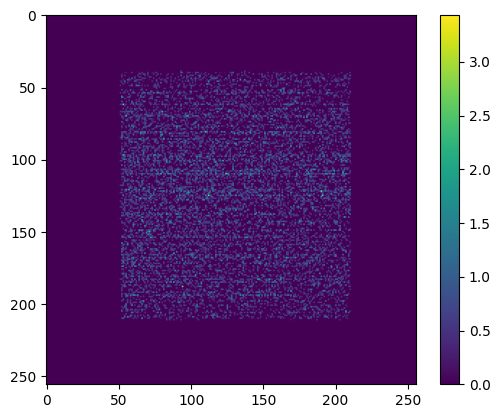

In [44]:
plt.imshow(hist.data_2D)
plt.colorbar()

In [45]:
hist.data_2D.sum()

7121.341279684484

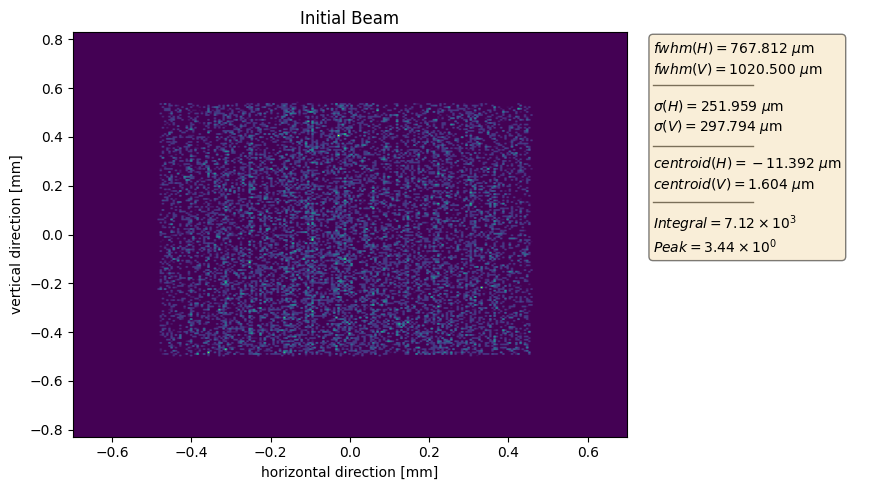

In [47]:
plot_distribution(
    beam=beam, title="Initial Beam", plot_mode=plot_mode, aspect_ratio=aspect_ratio, color_map=color_map,
    **sim_params

)

In [49]:
centroid_ground, *_ = opt_common.get_centroid_distance(photon_beam=beam, **sim_params)
sigma_ground, *_ = opt_common.get_sigma(photon_beam=beam, **sim_params)

In [50]:
print(f"centroid_ground: {centroid_ground:4.3e}, sigma_ground: {sigma_ground:4.3e}")

centroid_ground: 1.150e-02, sigma_ground: 3.901e-01


In [51]:
mots = list(move_motors_ranges.keys())
initial_absolute_positions = {k: movers.get_absolute_positions(focusing_system, k)[0] for k in mots}
print(initial_absolute_positions)

{'hb_pitch': 0.17188733853924987, 'vb_pitch': 0.17188733853924987}


In [52]:
initial_movement, focusing_system, (beam, hist, dw) = opt_common.get_random_init(
    focusing_system, motor_types_and_ranges=move_motors_ranges, intensity_sum_threshold=6.5e3,**sim_params
)

Random initialization is ['hb_pitch', 'vb_pitch'] [-0.001161390497958136, 8.464711160994847e-05]


### We can consider this the actual start of the experiment

In [102]:
focusing_system = movers.move_motors(
    focusing_system,
    list(move_motors_ranges.keys()),
    initial_movement + np.array(list(initial_absolute_positions.values())),
    movement="absolute",
)

centroid_init, beam_init, hist_init, dw_init = opt_common.get_centroid_distance(
    focusing_system=focusing_system, **sim_params
)
sigma_init = opt_common._get_sigma_from_dw(dw_init)
print(centroid_init, sigma_init)

0.17880674004406358 0.38899050328466794


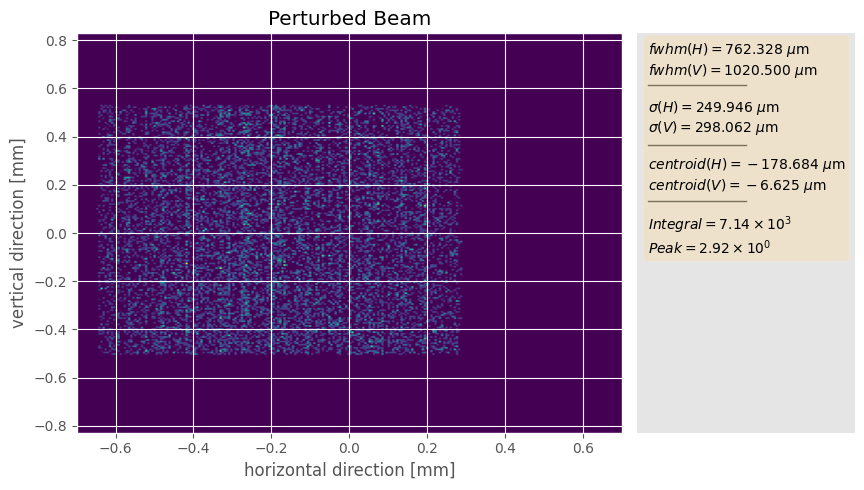

In [103]:
plot_distribution(
    beam=beam_init,
    title="Perturbed Beam",
    plot_mode=plot_mode,
    aspect_ratio=aspect_ratio,
    color_map=color_map,
    **sim_params
)

In [104]:
optimization_params = {
    "sum_intensity_soft_constraint": 6.5e3,
    "sum_intensity_hard_constraint": 6.5e3,
    "n_trials": 50,
}

In [105]:
opt_trial = OptunaOptimizer(
    focusing_system,
    motor_types=list(move_motors_ranges.keys()),
    loss_parameters=["centroid"],
    multi_objective_optimization=False,
    **sim_params
)

In [106]:
constraints = {"sum_intensity": optimization_params["sum_intensity_soft_constraint"], 'centroid': 4e-2}

opt_trial.set_optimizer_options(
    motor_ranges=list(move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=optimization_params["sum_intensity_hard_constraint"],
    constraints=constraints,
    acquisition_function='qnei'
    #moo_thresholds=moo_thresholds
)

[I 2022-11-16 12:34:48,849] A new study created in memory with name: no-name-1f5b59f7-e2be-48e1-8663-1e25cc8e260c


In [107]:
print("Optimizing only the pitch and translation motors")

Optimizing only the pitch and translation motors


In [110]:
opt_trial.trials(n_trials=optimization_params["n_trials"]
)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019200000000000007] and step=8e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00192].
  warnings.warn(
[I 2022-11-16 12:36:58,004] Trial 100 pruned. 


Pruning trial with parameters [-0.00193, -0.0014399999999999999]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019200000000000007] and step=8e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00192].
  warnings.warn(
[I 2022-11-16 12:36:59,097] Trial 101 pruned. 


Pruning trial with parameters [-0.00165, 0.0008000000000000004]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019200000000000007] and step=8e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00192].
  warnings.warn(
[I 2022-11-16 12:37:00,159] Trial 102 finished with value: 0.32776350436399343 and parameters: {'hb_pitch': -0.0007799999999999999, 'vb_pitch': 0.00168}. Best is trial 14 with value: 0.032027604583512365.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: Use

Pruning trial with parameters [-0.00165, 0.0008000000000000004]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019200000000000007] and step=8e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00192].
  warnings.warn(
[I 2022-11-16 12:37:06,627] Trial 108 pruned. 


Pruning trial with parameters [-0.00189, 0.0004000000000000002]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019200000000000007] and step=8e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00192].
  warnings.warn(
[I 2022-11-16 12:37:07,769] Trial 109 pruned. 


Pruning trial with parameters [-0.00198, 0.0018400000000000005]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019200000000000007] and step=8e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00192].
  warnings.warn(
[I 2022-11-16 12:37:08,919] Trial 110 finished with value: 0.16003174184364033 and parameters: {'hb_pitch': 0.0007100000000000001, 'vb_pitch': 0.0012800000000000003}. Best is trial 14 with value: 0.032027604583512365.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distribution

Pruning trial with parameters [-0.00166, 0.00031999999999999997]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019200000000000007] and step=8e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00192].
  warnings.warn(
[I 2022-11-16 12:37:11,162] Trial 112 finished with value: 0.16354170857774786 and parameters: {'hb_pitch': 0.0016500000000000004, 'vb_pitch': -0.00152}. Best is trial 14 with value: 0.032027604583512365.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: Use

Pruning trial with parameters [-0.0017000000000000001, 0.00152]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019200000000000007] and step=8e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00192].
  warnings.warn(
[I 2022-11-16 12:37:15,922] Trial 116 finished with value: 0.017575579704633373 and parameters: {'hb_pitch': 0.00136, 'vb_pitch': -7.999999999999978e-05}. Best is trial 116 with value: 0.017575579704633373.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: U

Pruning trial with parameters [-0.00129, -0.00047999999999999996]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019200000000000007] and step=8e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00192].
  warnings.warn(
[I 2022-11-16 12:37:37,796] Trial 132 finished with value: 0.0774391394242237 and parameters: {'hb_pitch': 0.0013000000000000004, 'vb_pitch': -0.0007999999999999999}. Best is trial 116 with value: 0.017575579704633373.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributio

Pruning trial with parameters [-0.00135, 0.00031999999999999997]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019200000000000007] and step=8e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00192].
  warnings.warn(
[I 2022-11-16 12:37:47,963] Trial 139 finished with value: 0.2539189692428777 and parameters: {'hb_pitch': -0.0002999999999999999, 'vb_pitch': 0.0011200000000000003}. Best is trial 116 with value: 0.017575579704633373.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributio

Pruning trial with parameters [-0.0013700000000000001, 0.00152]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019200000000000007] and step=8e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00192].
  warnings.warn(
[I 2022-11-16 12:37:52,283] Trial 142 finished with value: 0.25348789288276735 and parameters: {'hb_pitch': -0.00013999999999999993, 'vb_pitch': 0.0014400000000000003}. Best is trial 116 with value: 0.017575579704633373.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distribut

Pruning trial with parameters [-0.00158, 0.0011200000000000003]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019200000000000007] and step=8e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00192].
  warnings.warn(
[I 2022-11-16 12:37:59,802] Trial 147 pruned. 


Pruning trial with parameters [-0.00124, -0.00047999999999999996]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019200000000000007] and step=8e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00192].
  warnings.warn(
[I 2022-11-16 12:38:01,328] Trial 148 pruned. 


Pruning trial with parameters [-0.00168, -0.00104]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019200000000000007] and step=8e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00192].
  warnings.warn(
[I 2022-11-16 12:38:02,921] Trial 149 finished with value: 0.26294170818346624 and parameters: {'hb_pitch': -4.9999999999999914e-05, 'vb_pitch': -0.00184}. Best is trial 116 with value: 0.017575579704633373.


In [111]:
opt_trial.study.best_trials

[FrozenTrial(number=116, values=[0.017575579704633373], datetime_start=datetime.datetime(2022, 11, 16, 12, 37, 14, 736300), datetime_complete=datetime.datetime(2022, 11, 16, 12, 37, 15, 922304), params={'hb_pitch': 0.00136, 'vb_pitch': -7.999999999999978e-05}, distributions={'hb_pitch': FloatDistribution(high=0.00199, log=False, low=-0.002, step=1e-05), 'vb_pitch': FloatDistribution(high=0.00192, log=False, low=-0.002, step=8e-05)}, user_attrs={'sum_intensity_constraint': -1, 'centroid_constraint': -1, 'dw': <aps.common.ml.data_structures.DictionaryWrapper object at 0x7f9a91b74910>}, system_attrs={'constraints': (-1, -1)}, intermediate_values={}, trial_id=116, state=TrialState.COMPLETE, value=None)]

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_9578/4040887776.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(opt_trial.study, target_name="centroid")


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='centroid'>

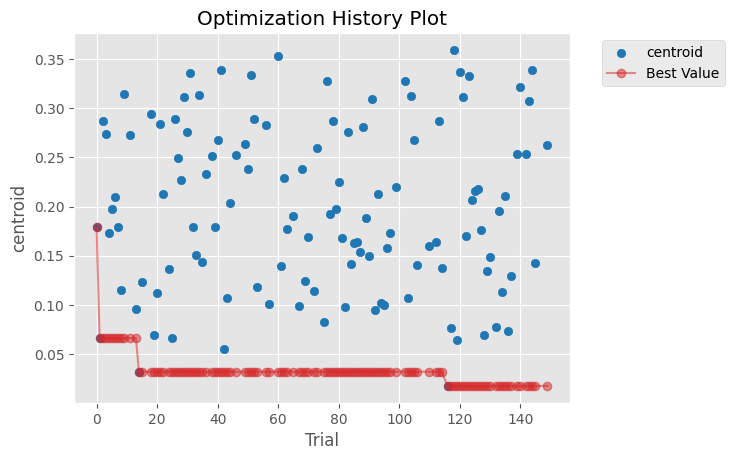

In [118]:
optuna.visualization.matplotlib.plot_optimization_history(opt_trial.study, target_name="centroid")

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_9578/1592859794.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(opt_trial.study)


<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

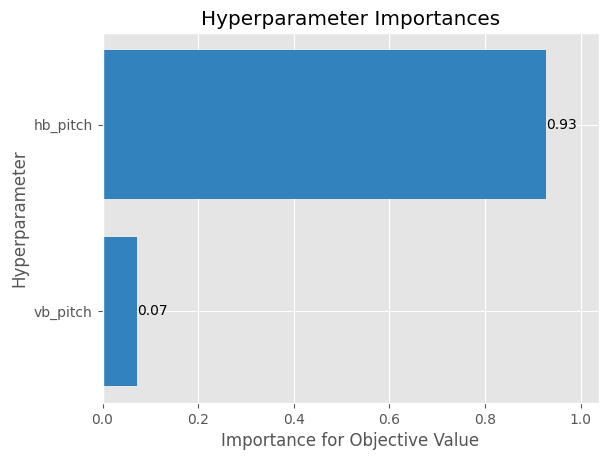

In [113]:
optuna.visualization.matplotlib.plot_param_importances(opt_trial.study)

In [114]:
opt_trial.study.best_params, opt_trial.study.best_value

({'hb_pitch': 0.00136, 'vb_pitch': -7.999999999999978e-05},
 0.017575579704633373)

In [115]:
opt_trial.study.best_params

{'hb_pitch': 0.00136, 'vb_pitch': -7.999999999999978e-05}

0.01757557970463336


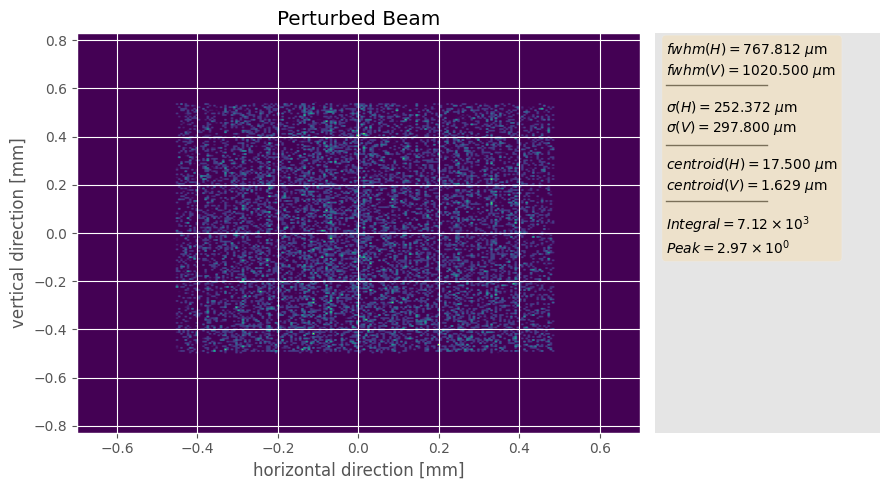

In [116]:
params = opt_trial.study.best_params
vals = opt_trial.study.best_value
current_params = []
for mot in opt_trial.motor_types:
    current_params.append(params[mot])
print(opt_trial._loss_fn_this(current_params))
plot_distribution(beam=opt_trial.beam_state.photon_beam,
    title="Perturbed Beam",
    plot_mode=plot_mode,
    aspect_ratio=aspect_ratio,
    color_map=color_map,
    **sim_params)

In [84]:
datetime_str = datetime.strftime(datetime.now(), "%Y:%m:%d:%H:%M")
joblib.dump(opt_trial.study.trials, f"optimization_checkpoint_50_{datetime_str}.pkl")

['optimization_checkpoint_50_2022:11:15:02:03.pkl']

In [62]:
print("Optimizing all motors together")

Optimizing all motors together


In [63]:
opt_trial.trials(optimization_params["n_all_motor_trials"])

[I 2022-11-15 01:51:20,134] Trial 50 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
Pruning trial with parameters [21.0, -115.0, 0.0027800000000000012, 40.0, 124.0, -0.006, -41.5]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:51:22,509] Trial 51 finished with values: [0.02830217284768545, 0.16470550537825013] and parameters: {'hb_1': 73.0, 'hb_2': 39.0, 'hb_pitch': -0.001299999999999999, 'hb_trans': 40.5, 'vb_bender': -160.0, 'vb_pitch': -0.0102, 'vb_trans': -36.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:51:25,180] Trial 52 finished with values: [0.06358200910227427, 0.3231781529717705] and parameters: {'hb_1': -3.0, 'hb_2': 34.0, 'hb_pitch': -0.0036799999999999992, 'hb_trans': 19.0, 'vb_bender': -478.0, 'vb_pitch': -0.006, 'vb_trans': -35.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:51:27,933] Trial 53 finished with values: [0.04309473200122316, 0.13431964660081191] and parameters: {'hb_1': -58.0, 'hb_2': -85.0, 'hb_pitch': 0.004140000000000001, 'hb_trans': 28.5, 'vb_bender': -12.0, 'vb_pitch': 0.0052, 'vb_trans': 3.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:51:30,302] Trial 54 finished with values: [0.024994079273516212, 0.18913298533624423] and parameters: {'hb_1': 49.0, 'hb_2': 90.0, 'hb_pitch': 0.0066900000000000015, 'hb_trans': 36.5, 'vb_bender': 7.0, 'vb_pitch': -0.013000000000000001, 'vb_trans': -38.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-15 01:51:33,132] Trial 55 pruned. 


Pruning trial with parameters [8.0, -49.0, -0.002999999999999999, 3.5, 70.0, -0.0017999999999999995, -5.0]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:51:35,880] Trial 56 finished with values: [0.06645400625795979, 0.11590309222386226] and parameters: {'hb_1': 14.0, 'hb_2': -68.0, 'hb_pitch': -0.002489999999999999, 'hb_trans': 13.5, 'vb_bender': -68.0, 'vb_pitch': -0.011600000000000001, 'vb_trans': -27.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-15 01:51:38,992] Trial 57 pruned. 


Pruning trial with parameters [-72.0, 60.0, -0.000619999999999999, 22.5, 73.0, -0.0032000000000000015, -35.5]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:51:43,229] Trial 58 finished with values: [0.02158236015948021, 0.1084205648239167] and parameters: {'hb_1': 10.0, 'hb_2': -23.0, 'hb_pitch': 0.0029500000000000012, 'hb_trans': 50.0, 'vb_bender': -26.0, 'vb_pitch': 0.0108, 'vb_trans': 24.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:51:46,865] Trial 59 finished with values: [0.03808553662317063, 0.08124882882060785] and parameters: {'hb_1': -44.0, 'hb_2': 2.0, 'hb_pitch': 0.0031200000000000012, 'hb_trans': 50.0, 'vb_bender': -22.0, 'vb_pitch': 0.0108, 'vb_trans': 22.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:51:57,177] Trial 60 finished with values: [0.014355973606555739, 0.08388380934860046] and parameters: {'hb_1': -21.0, 'hb_2': 0.0, 'hb_pitch': 0.0015900000000000011, 'hb_trans': 35.0, 'vb_bender': -43.0, 'vb_pitch': -0.00040000000000000105, 'vb_trans': -14.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:52:00,195] Trial 61 finished with values: [0.01073373350001027, 0.09109582876085563] and parameters: {'hb_1': -5.0, 'hb_2': 11.0, 'hb_pitch': 0.0014200000000000011, 'hb_trans': 33.5, 'vb_bender': -57.0, 'vb_pitch': -0.0017999999999999995, 'vb_trans': -18.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:52:04,389] Trial 62 finished with values: [0.03551945083696415, 0.07235674555524108] and parameters: {'hb_1': -27.0, 'hb_2': 19.0, 'hb_pitch': 0.0032900000000000013, 'hb_trans': 50.0, 'vb_bender': -60.0, 'vb_pitch': -0.0088, 'vb_trans': -45.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:52:07,019] Trial 63 finished with values: [0.18538568828518762, 0.08938787712710375] and parameters: {'hb_1': -92.0, 'hb_2': 73.0, 'hb_pitch': -0.00827, 'hb_trans': 20.5, 'vb_bender': 13.0, 'vb_pitch': -0.0102, 'vb_trans': 3.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-15 01:52:10,085] Trial 64 pruned. 


Pruning trial with parameters [16.0, 10.0, -0.002149999999999999, 20.0, 830.0, -0.0017999999999999995, 0.0]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:52:13,176] Trial 65 finished with values: [0.08330469697109381, 0.07832308409913291] and parameters: {'hb_1': -74.0, 'hb_2': 111.0, 'hb_pitch': 0.018250000000000006, 'hb_trans': 47.0, 'vb_bender': -79.0, 'vb_pitch': 0.0164, 'vb_trans': -5.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:52:16,458] Trial 66 finished with values: [0.03706923382478308, 0.13360035108492627] and parameters: {'hb_1': -66.0, 'hb_2': 86.0, 'hb_pitch': 0.0063500000000000015, 'hb_trans': -40.0, 'vb_bender': -10.0, 'vb_pitch': 0.006599999999999998, 'vb_trans': -8.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:52:21,296] Trial 67 finished with values: [0.03691114892545638, 0.08462720790743519] and parameters: {'hb_1': -9.0, 'hb_2': 35.0, 'hb_pitch': 0.0032900000000000013, 'hb_trans': 50.0, 'vb_bender': -74.0, 'vb_pitch': 0.0108, 'vb_trans': 24.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:52:25,517] Trial 68 finished with values: [0.013492111327804812, 0.07474965650361363] and parameters: {'hb_1': -29.0, 'hb_2': -15.0, 'hb_pitch': -0.001299999999999999, 'hb_trans': 12.0, 'vb_bender': -78.0, 'vb_pitch': -0.006, 'vb_trans': -50.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:52:39,826] Trial 69 finished with values: [0.006915818707234751, 0.07885874945677329] and parameters: {'hb_1': -20.0, 'hb_2': -14.0, 'hb_pitch': 0.0009100000000000011, 'hb_trans': 28.0, 'vb_bender': -90.0, 'vb_pitch': -0.0032000000000000015, 'vb_trans': -33.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:52:48,604] Trial 70 finished with values: [0.012652692731654229, 0.07140455373780918] and parameters: {'hb_1': -36.0, 'hb_2': -15.0, 'hb_pitch': 0.0012500000000000011, 'hb_trans': 29.5, 'vb_bender': -79.0, 'vb_pitch': -0.0046, 'vb_trans': -39.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:52:59,338] Trial 71 finished with values: [0.0051547593480807015, 0.07288034367253415] and parameters: {'hb_1': -37.0, 'hb_2': -26.0, 'hb_pitch': -0.001129999999999999, 'hb_trans': 7.0, 'vb_bender': -83.0, 'vb_pitch': -0.0032000000000000015, 'vb_trans': -30.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:53:03,094] Trial 72 finished with values: [0.09094047176566206, 0.06525727451622391] and parameters: {'hb_1': -113.0, 'hb_2': 100.0, 'hb_pitch': 0.010600000000000002, 'hb_trans': 6.0, 'vb_bender': -67.0, 'vb_pitch': 0.003799999999999998, 'vb_trans': -36.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:53:10,346] Trial 73 finished with values: [0.016107950025079112, 0.05984202937363222] and parameters: {'hb_1': -55.0, 'hb_2': -16.0, 'hb_pitch': -0.001299999999999999, 'hb_trans': 0.0, 'vb_bender': -93.0, 'vb_pitch': -0.0032000000000000015, 'vb_trans': -33.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:53:27,977] Trial 74 finished with values: [0.013878965527256853, 0.08010436516595966] and parameters: {'hb_1': -59.0, 'hb_2': -45.0, 'hb_pitch': -0.000959999999999999, 'hb_trans': 11.0, 'vb_bender': -110.0, 'vb_pitch': -0.0017999999999999995, 'vb_trans': -35.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:53:45,565] Trial 75 finished with values: [0.012858582751194616, 0.08028418445931129] and parameters: {'hb_1': -33.0, 'hb_2': -28.0, 'hb_pitch': -0.0038499999999999993, 'hb_trans': -22.5, 'vb_bender': -100.0, 'vb_pitch': -0.0046, 'vb_trans': -35.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:53:53,949] Trial 76 finished with values: [0.012683577639761003, 0.083587657436886] and parameters: {'hb_1': -18.0, 'hb_2': -24.0, 'hb_pitch': -0.000279999999999999, 'hb_trans': 14.5, 'vb_bender': -79.0, 'vb_pitch': -0.0032000000000000015, 'vb_trans': -30.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:54:21,470] Trial 77 finished with values: [0.009871050663428046, 0.06738111484785454] and parameters: {'hb_1': -52.0, 'hb_2': -30.0, 'hb_pitch': -0.0018099999999999991, 'hb_trans': -1.5, 'vb_bender': -88.0, 'vb_pitch': -0.0074, 'vb_trans': -36.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:54:36,019] Trial 78 finished with values: [0.017122709398784037, 0.07186146762380809] and parameters: {'hb_1': -46.0, 'hb_2': -31.0, 'hb_pitch': -0.0038499999999999993, 'hb_trans': 3.0, 'vb_bender': -73.0, 'vb_pitch': -0.0046, 'vb_trans': -37.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:54:45,935] Trial 79 finished with values: [0.01671114529007322, 0.07241939238005543] and parameters: {'hb_1': -47.0, 'hb_2': -34.0, 'hb_pitch': -0.00010999999999999899, 'hb_trans': -7.0, 'vb_bender': -74.0, 'vb_pitch': -0.006, 'vb_trans': -38.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:55:10,875] Trial 80 finished with values: [0.00628391334500529, 0.06571942207274441] and parameters: {'hb_1': -65.0, 'hb_2': -36.0, 'hb_pitch': -0.0018099999999999991, 'hb_trans': -10.0, 'vb_bender': -90.0, 'vb_pitch': -0.0017999999999999995, 'vb_trans': -13.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:55:45,957] Trial 81 finished with values: [0.005263214825335906, 0.0733731441065847] and parameters: {'hb_1': -89.0, 'hb_2': -53.0, 'hb_pitch': -0.002999999999999999, 'hb_trans': -23.0, 'vb_bender': -89.0, 'vb_pitch': -0.0017999999999999995, 'vb_trans': -14.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:56:13,834] Trial 82 finished with values: [0.011216053810391211, 0.05278501466031434] and parameters: {'hb_1': -87.0, 'hb_2': -29.0, 'hb_pitch': -0.0033399999999999992, 'hb_trans': -37.5, 'vb_bender': -88.0, 'vb_pitch': -0.0017999999999999995, 'vb_trans': -15.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:56:40,858] Trial 83 finished with values: [0.02065238778451588, 0.06168148665325269] and parameters: {'hb_1': -85.0, 'hb_2': -39.0, 'hb_pitch': -0.002659999999999999, 'hb_trans': -23.5, 'vb_bender': -88.0, 'vb_pitch': 0.003799999999999998, 'vb_trans': -12.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:57:07,590] Trial 84 finished with values: [0.029985796156070034, 0.0612909031483624] and parameters: {'hb_1': -91.0, 'hb_2': -40.0, 'hb_pitch': -0.002659999999999999, 'hb_trans': -27.0, 'vb_bender': -89.0, 'vb_pitch': -0.0074, 'vb_trans': -16.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:57:28,135] Trial 85 finished with values: [0.00929147377768629, 0.07053025002220185] and parameters: {'hb_1': -63.0, 'hb_2': -46.0, 'hb_pitch': -0.0038499999999999993, 'hb_trans': -27.5, 'vb_bender': -89.0, 'vb_pitch': -0.0017999999999999995, 'vb_trans': -15.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:57:55,234] Trial 86 finished with values: [0.0012042910412994416, 0.06204164542826176] and parameters: {'hb_1': -78.0, 'hb_2': -38.0, 'hb_pitch': -0.001979999999999999, 'hb_trans': -23.0, 'vb_bender': -87.0, 'vb_pitch': -0.0017999999999999995, 'vb_trans': -20.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:57:58,975] Trial 87 finished with values: [0.10305317055764253, 0.08053717410291723] and parameters: {'hb_1': -142.0, 'hb_2': 14.0, 'hb_pitch': 0.014340000000000002, 'hb_trans': 41.0, 'vb_bender': -106.0, 'vb_pitch': -0.0158, 'vb_trans': 12.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:58:03,282] Trial 88 pruned. 


Pruning trial with parameters [-199.0, 88.0, 0.015189999999999999, -12.0, -106.0, 0.0178, 37.0]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:58:07,333] Trial 89 pruned. 


Pruning trial with parameters [-129.0, 15.0, 0.0066900000000000015, 11.0, -94.0, 0.0178, 45.0]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:58:11,126] Trial 90 finished with values: [0.07120104340097129, 0.06053845715147644] and parameters: {'hb_1': -67.0, 'hb_2': 44.0, 'hb_pitch': 0.009410000000000002, 'hb_trans': 33.0, 'vb_bender': -147.0, 'vb_pitch': -0.02, 'vb_trans': -47.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:58:14,345] Trial 91 finished with values: [0.17117065778006427, 0.06537662775089118] and parameters: {'hb_1': -144.0, 'hb_2': 31.0, 'hb_pitch': -0.00963, 'hb_trans': -41.0, 'vb_bender': -172.0, 'vb_pitch': 0.0192, 'vb_trans': -39.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:58:17,818] Trial 92 finished with values: [0.0947522032750505, 0.055465618789324565] and parameters: {'hb_1': -144.0, 'hb_2': 105.0, 'hb_pitch': 0.019610000000000006, 'hb_trans': 44.5, 'vb_bender': -125.0, 'vb_pitch': -0.00040000000000000105, 'vb_trans': 35.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:58:21,617] Trial 93 finished with values: [0.1830113982542084, 0.11293853699921036] and parameters: {'hb_1': -200.0, 'hb_2': 46.0, 'hb_pitch': 0.0027800000000000012, 'hb_trans': 29.0, 'vb_bender': -155.0, 'vb_pitch': 0.009399999999999999, 'vb_trans': -28.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-15 01:58:25,178] Trial 94 pruned. 


Pruning trial with parameters [-137.0, 166.0, 0.017400000000000002, -18.0, 657.0, 0.006599999999999998, -0.5]


[I 2022-11-15 01:58:28,518] Trial 95 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
Pruning trial with parameters [-131.0, -166.0, 0.015189999999999999, 21.0, -729.0, -0.0017999999999999995, 3.0]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:58:32,211] Trial 96 pruned. 


Pruning trial with parameters [-104.0, 53.0, -0.001129999999999999, -29.0, -120.0, 0.0192, 50.0]


[I 2022-11-15 01:58:35,479] Trial 97 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
Pruning trial with parameters [152.0, -110.0, -0.001129999999999999, 11.0, 495.0, -0.018600000000000002, -15.0]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-15 01:58:38,650] Trial 98 finished with values: [0.0168775024881796, 0.055820064742191984] and parameters: {'hb_1': -115.0, 'hb_2': 3.0, 'hb_pitch': 0.012300000000000002, 'hb_trans': 0.0, 'vb_bender': -38.0, 'vb_pitch': -0.0088, 'vb_trans': -35.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-15 01:58:41,598] Trial 99 pruned. 


Pruning trial with parameters [109.0, 135.0, 0.008730000000000002, 34.0, 738.0, -0.011600000000000001, -42.5]


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_9578/995896856.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(


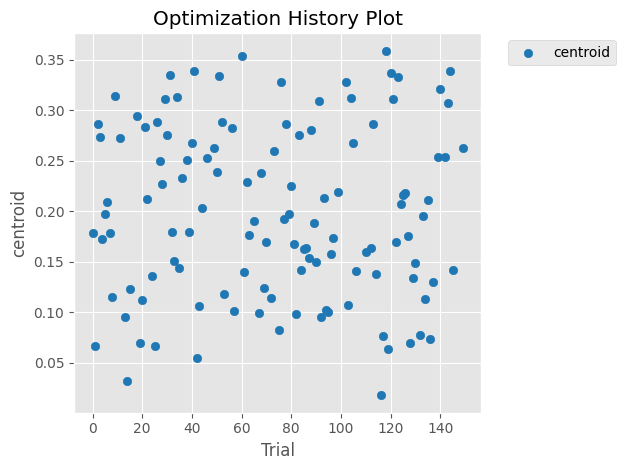

In [121]:
optuna.visualization.matplotlib.plot_optimization_history(
    study=opt_trial.study, target=lambda t: t.values[0], target_name="centroid"
)
plt.tight_layout()
plt.savefig('optimization_history.png')

In [74]:
optimal_params, values = select_best_trial_params(opt_trial.study.best_trials)

In [75]:
optimal_params, values

({'hb_1': -87.0,
  'hb_2': -29.0,
  'hb_pitch': -0.0033399999999999992,
  'hb_trans': -37.5,
  'vb_bender': -88.0,
  'vb_pitch': -0.0017999999999999995,
  'vb_trans': -15.0},
 [0.011216053810391211, 0.05278501466031434])

In [76]:
initial_movement

[135.16917904768525,
 -36.05448803397144,
 -0.014481142591426997,
 41.85642548717669,
 90.49112876710194,
 0.0017745091189553322,
 19.31957193850937]

In [77]:
opt_trial._loss_fn_this(list(optimal_params.values()))
#plot_distribution(beam=opt_trial.beam_state.photon_beam, implementor=Implementors.SHADOW)# **sim_params)

array([0.00926111, 0.05276798])

In [ ]:
datetime_str = datetime.strftime(datetime.now(), "%Y:%m:%d:%H:%M")
joblib.dump(opt_trial.study.trials, f"optimization_final_100_{datetime_str}.pkl")